# Transfer-Learning , Scaled Up models 

### Beating 50.76% Accuracy , accross all classes 
#### Mini Models : 101 classes of data with 10% input 


In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("CUDA Support:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-03-06 21:39:28.461340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741293568.512743    8245 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741293568.527502    8245 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 21:39:28.638260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA Support: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Import Helper Functions 

In [3]:
from helper import *

In [4]:
# 101 Classes of data 
train_dir = "101_food_classes_10_percent/101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/101_food_classes_10_percent/test"

In [5]:
walk_through_dir("/home/akhil/Documents/Tf_Local/101_food_classes_10_percent")

There are 2 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent'.
There are 1 directories and 1 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX'.
There are 1 directories and 2 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX/101_food_classes_10_percent'.
There are 0 directories and 34 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX/101_food_classes_10_percent/test'.
There are 2 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10

In [6]:
# Set up data input

import tensorflow as tf
import tf_keras
IMG_SIZE = (224 ,224)
train_data_all_10_percent = tf_keras.preprocessing.image_dataset_from_directory(train_dir ,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf_keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False ) # Dont Shuffle the  test daata for prediction analysis 



Found 7575 files belonging to 101 classes.


I0000 00:00:1741293572.878869    8245 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5201 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 25250 files belonging to 101 classes.


- Model Checkpoit 
- Data augmentation layer 
- Build headless fnctional efficientB0 model 
- Compile 
- Feeature Extract for 5 full passes on training data
- Validate on 15 % of Test data 



In [7]:
# Training teh transfer learning model with 10 percent of the data 

# Create Checkpoint Callback 
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only= True,
                                                         monitor= "accuracy",
                                                         save_best_only=True)

## Pushing Data Augmentaion on GPU 💷

In [8]:
# Data Augmentation Layer

from tf_keras import layers
from tf_keras.layers.experimental import preprocessing 
from tf_keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)  #Rescaling is not required in this case , but required in the resnet models
     
], name = "data_augmentation")


In [9]:
# Headless model , with Functional API 
# Baase Model , freeaze some layers

base_model = tf_keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Model Architechure with trinable top layers

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)  # Computed on GPU during Training phase 
x = base_model(x, training = False) # Freezed Layers 
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation = "softmax")(x)
model = tf_keras.Model(inputs, outputs)

# Compile the model

model.compile(loss = "categorical_crossentropy",
              optimizer = tf_keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model

history_10_percent = model.fit(train_data_all_10_percent,
                               epochs = 5,
                               steps_per_epoch = len(train_data_all_10_percent),
                               validation_data = test_data,
                               validation_steps = int(0.15 * len(test_data)),
                               callbacks = [checkpoint_callback])



Epoch 1/5


I0000 00:00:1741293586.005561    8752 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/237 [..............................] - ETA: 29:27 - loss: 4.7590 - accuracy: 0.0312

I0000 00:00:1741293586.504934    8754 service.cc:148] XLA service 0x7473641150f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741293586.505017    8754 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-06 21:39:46.512366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741293586.601762    8754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 46s 165ms/step - loss: 3.3650 - accuracy: 0.2779 - val_loss: 2.5369 - val_accuracy: 0.4497
Epoch 2/5
237/237 [==============================] - 38s 158ms/step - loss: 2.1963 - accuracy: 0.5003 - val_loss: 2.0765 - val_accuracy: 0.5003
Epoch 3/5
237/237 [==============================] - 37s 154ms/step - loss: 1.8202 - accuracy: 0.5650 - val_loss: 1.9191 - val_accuracy: 0.5193
Epoch 4/5
237/237 [==============================] - 37s 155ms/step - loss: 1.6103 - accuracy: 0.6069 - val_loss: 1.8559 - val_accuracy: 0.5140
Epoch 5/5
237/237 [==============================] - 35s 150ms/step - loss: 1.4548 - accuracy: 0.6417 - val_loss: 1.8317 - val_accuracy: 0.5167


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [11]:
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 42s 53ms/step - loss: 1.5791 - accuracy: 0.5842


[1.5790555477142334, 0.5841584205627441]

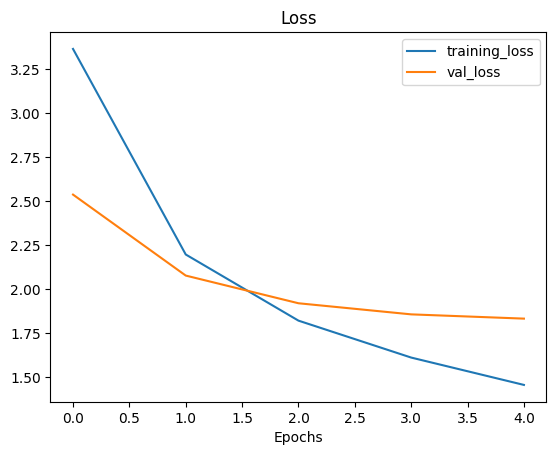

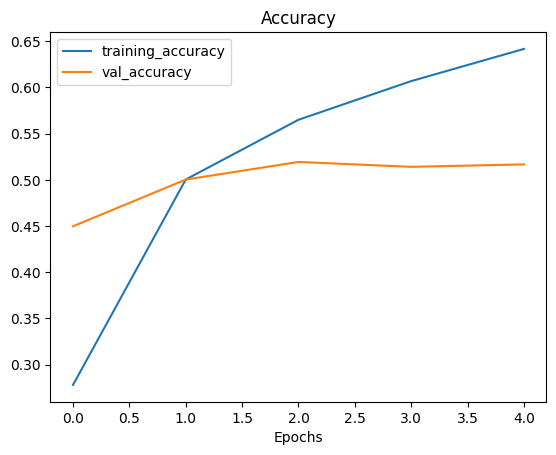

In [12]:
# Plotting loss curves 

plot_loss_curves(history_10_percent)

In [13]:
# Curves separating in the end , means model is overfitting : performing too well on training data , and not genralizing on the unseen data 

## Fine Tuning 

---
- When unfreezing a layer make the learning rate slow 
- Unfreeze all of the layers in the base_model 
- Unfreezing last 5 layers , 
- Last layers are responsible , for the larger features

In [14]:
# Unfreeze all of the layers in the base_model 
base_model.trainable = True 

# Refreeze 

for layer in base_model.layers[:-5]: # Unfrozen last 5 layerss
    layer.trainable = False

In [15]:
# Recompile , model with lower learning rate
model.compile(loss = "categorical_crossentropy",
              optimizer = tf_keras.optimizers.Adam(learning_rate = 0.0001), # learning rate lowered by 10x
              metrics = ["accuracy"])


In [16]:
# looking for the trainable layers in the model 

for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling2d True
dense True


In [17]:
# Checking for the trainable layers in the base_model 

for layer_number , layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)



# This should show that the last 5 layers should be trainable , and every other layer should be frozen

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.multiply False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [18]:
# Model Fine-Tuning : starting the training  from the epoch left behind last time 

fine_tune_epochs = 10 # model has already trained for 5 epochs , resumin from that point 
# Fine -Tune 

history_all_classes_10_percent_fine_tune = model.fit (train_data_all_10_percent,
                                                       epochs = fine_tune_epochs,
                                                       validation_data = test_data,
                                                       validation_steps = int(0.15 * len(test_data)),
                                                       initial_epoch = history_10_percent.epoch[-1])




Epoch 5/10


237/237 [==============================] - 161s 640ms/step - loss: 1.2088 - accuracy: 0.6855 - val_loss: 1.7127 - val_accuracy: 0.5477
Epoch 6/10
237/237 [==============================] - 102s 429ms/step - loss: 1.0924 - accuracy: 0.7134 - val_loss: 1.6967 - val_accuracy: 0.5553
Epoch 7/10
237/237 [==============================] - 88s 370ms/step - loss: 1.0140 - accuracy: 0.7290 - val_loss: 1.6885 - val_accuracy: 0.5514
Epoch 8/10
237/237 [==============================] - 76s 321ms/step - loss: 0.9414 - accuracy: 0.7489 - val_loss: 1.6745 - val_accuracy: 0.5543
Epoch 9/10
237/237 [==============================] - 69s 291ms/step - loss: 0.8796 - accuracy: 0.7603 - val_loss: 1.7666 - val_accuracy: 0.5379
Epoch 10/10
237/237 [==============================] - 61s 258ms/step - loss: 0.8293 - accuracy: 0.7747 - val_loss: 1.7208 - val_accuracy: 0.5493


In [19]:
# Evaluate on the full Test Data 

all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results


790/790 [==============================] - 40s 51ms/step - loss: 1.4910 - accuracy: 0.6038


[1.491006851196289, 0.603801965713501]

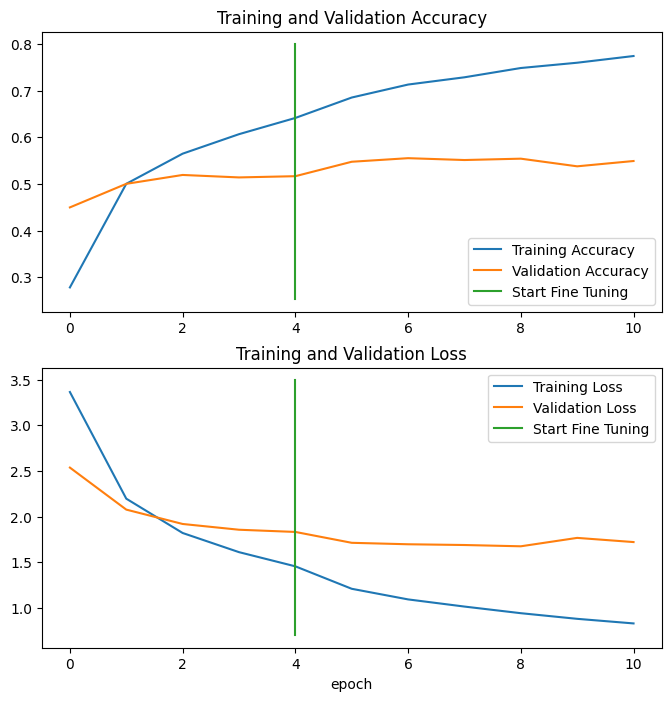

In [20]:
# Compare the histories , with feature extraction models , with fine tune models

compare_historys(original_history = history_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

In [21]:
# Saving and Loading the model 

model.save("101_classes_10_percent_saved_model")

INFO:tensorflow:Assets written to: 101_classes_10_percent_saved_model/assets


INFO:tensorflow:Assets written to: 101_classes_10_percent_saved_model/assets


In [22]:
loaded_model = tf_keras.models.load_model("101_classes_10_percent_saved_model")

In [23]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 42s 52ms/step - loss: 1.4910 - accuracy: 0.6038


[1.491006851196289, 0.603801965713501]

In [24]:
# Evaluating the performance of the model , accross all the different classes
# Making predictions and plotting them 

import numpy as np
from tf_keras import utils


# uSING A ALREADY BUILT FINE TUNE MODEL 

# Load the saved model

model = tf_keras.models.load_model("/home/akhil/Documents/Tf_Local/06_101_food_class_10_percent_saved_big_dog_model (2)/06_101_food_class_10_percent_saved_big_dog_model")


In [25]:
# Evaluate the loaded model ( in test data)

results_premade_model = model.evaluate(test_data)
results_premade_model

790/790 [==============================] - 41s 51ms/step - loss: 1.8022 - accuracy: 0.6078


[1.8021925687789917, 0.6078416109085083]

In [26]:
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 39s 48ms/step


In [27]:
len(test_data)

790

In [28]:
790*32

25280

In [29]:
# How many predictions are there ?

len(preds_probs)

25250

In [30]:
# What is the shape of the PRedictions ?
preds_probs.shape

(25250, 101)

In [31]:
# What are the 10 first predictions ?
preds_probs[:10]

array([[5.9386708e-02, 3.5747303e-06, 4.1280869e-02, ..., 1.4112708e-09,
        8.3762250e-05, 3.0842533e-03],
       [9.6350169e-01, 1.3720646e-09, 8.4753177e-04, ..., 5.4724285e-05,
        7.8266577e-12, 9.7968811e-10],
       [9.5956594e-01, 3.2370048e-05, 1.4756998e-03, ..., 7.1490882e-07,
        5.4971537e-07, 4.0044932e-05],
       ...,
       [4.7309124e-01, 1.2900098e-07, 1.4718017e-03, ..., 5.9502193e-04,
        6.7334659e-05, 2.3502811e-05],
       [4.4531006e-02, 4.7604877e-07, 1.2223568e-01, ..., 6.3220350e-06,
        7.5684193e-06, 3.6753835e-03],
       [7.2422320e-01, 1.9260369e-09, 5.2292740e-05, ..., 1.2220119e-03,
        1.5770126e-09, 9.6254575e-05]], dtype=float32)

In [32]:
# Shape of the arraat of the first prediction 
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9386708e-02, 3.5747303e-06, 4.1280869e-02, 1.0592210e-09,
        8.1656948e-09, 8.5725880e-09, 8.0980789e-07, 8.4500476e-07,
        1.9760229e-05, 7.9796638e-07, 3.1705121e-09, 9.7980217e-07,
        2.8393482e-04, 7.7416706e-10, 7.3978468e-04, 3.8668364e-05,
        6.4538913e-06, 2.4955355e-06, 3.7628870e-05, 2.0478858e-07,
        1.5546590e-05, 8.0694463e-07, 2.6047994e-06, 2.0285646e-07,
        8.2894064e-07, 5.4123880e-06, 3.7363448e-06, 1.3161273e-08,
        2.7436682e-03, 2.7954495e-05, 6.8107542e-10, 2.5341104e-05,
        1.6642838e-04, 7.5475942e-10, 4.0284812e-04, 1.3077920e-08,
        1.7873915e-06, 1.4374262e-06, 2.3150882e-02, 8.2202712e-07,
        8.5741175e-07, 1.6920036e-06, 7.0452434e-06, 1.8502085e-08,
        2.8571301e-07, 7.9483316e-06, 2.0710429e-06, 1.8579009e-07,
        3.3334356e-08, 3.1635989e-04, 1.0483816e-05, 8.5382464e-07,
        8.4773231e-01, 1.0542810e-05, 4.3458138e-07, 3.7250396e-05,
        3.5064731e-05, 3.2475069e-05, 6.7055254e

## Model Description 

The model outputs the prediction probability array (with) N number of variables , where N is the number of classes , for each sample , passed to the prediction model.

In [33]:
# We get one prediction probability per class , in 101 classes dataset 
print(f"Number of the prediction probability samples for 0 th sample : {len(preds_probs[0])}")
print(f"Sum of the prediction probability samples for 0 th sample : {sum(preds_probs[0])}")
print(f"Max of the prediction probability samples for 0 th sample : {np.max(preds_probs[0])}")
print(f"Index of the max prediction probability sample for 0 th sample : {np.argmax(preds_probs[0])}")



Number of the prediction probability samples for 0 th sample : 101
Sum of the prediction probability samples for 0 th sample : 1.000000238418579
Max of the prediction probability samples for 0 th sample : 0.8477323055267334
Index of the max prediction probability sample for 0 th sample : 52


In [34]:
test_data.class_names[52]

'gyoza'

In [35]:
# Get pred classes of each label 

pred_classes = preds_probs.argmax(axis = 1)

# What are the predicted classes for the first 10 samples ?
pred_classes[:10]
len(pred_classes)

25250

To Evaluate the model predictions we need ot compare the labels


In [36]:
# TO get the test labels , the test_data BatchDataset has ot be unbatched
y_labels = []
for images , labels in test_data.unbatch().as_numpy_iterator():
    y_labels.append(labels.argmax())

2025-03-06 21:56:21.983075: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

### Checking if the model's prediction array is in the same order as in the test data

In [38]:
results_premade_model

[1.8021925687789917, 0.6078416109085083]

### Trying the Scikit- Learn Accuracy Score

In [39]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6078415841584158

### Does this metric come close to our model's evaluate results 

 

In [40]:
np.isclose(results_premade_model[1], sklearn_accuracy)

np.True_

## Making a confusion matrix for all the food data 

In [42]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (50,50),
                      text_size = 10)

## Continuing the Evaluation 

- using the function from scikit-learn , precision , recall and f1
- As the f1 is the combination of precision and recall , plotting the recall for the classes



In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, target_names = class_names))

                         precision    recall  f1-score   support

              apple_pie       0.29      0.20      0.24       250
         baby_back_ribs       0.51      0.69      0.59       250
                baklava       0.56      0.65      0.60       250
         beef_carpaccio       0.74      0.53      0.62       250
           beef_tartare       0.73      0.44      0.55       250
             beet_salad       0.34      0.54      0.42       250
               beignets       0.67      0.79      0.72       250
               bibimbap       0.82      0.76      0.79       250
          bread_pudding       0.40      0.37      0.39       250
      breakfast_burrito       0.62      0.44      0.51       250
             bruschetta       0.62      0.42      0.50       250
           caesar_salad       0.83      0.48      0.61       250
                cannoli       0.52      0.74      0.61       250
          caprese_salad       0.56      0.60      0.58       250
            carrot_cake 

In [59]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7315436241610739,
  'recall': 0.436,
  'f1-score': 0.5463659147869674,
  'support': 250.0},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'supp

In [60]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [61]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5463659147869674,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.503562945368171,
 'caesar_salad': 0.6126582278481013,
 'cannoli': 0.6135986733001658,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.5736434108527132,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.426890756302521,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45325779036827196,
 'chocolate_mousse': 0.32857142857142857,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee

In [62]:
# tURN f1 SCORES INTO DATAFRAMES , FOR VISUALIZATION

import pandas as pd 

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),"f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores

,class_names,f1-score
33,edamame,0.935361
63,macarons,0.895397
75,pho,0.869903
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.335196
22,chocolate_mousse,0.328571
77,pork_chop,0.308756
39,foie_gras,0.298025


/tmp/ipykernel_8245/3758151624.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  scores = sns.barplot(x = "f1-score", y = "class_names", data = f1_scores, palette = "viridis")


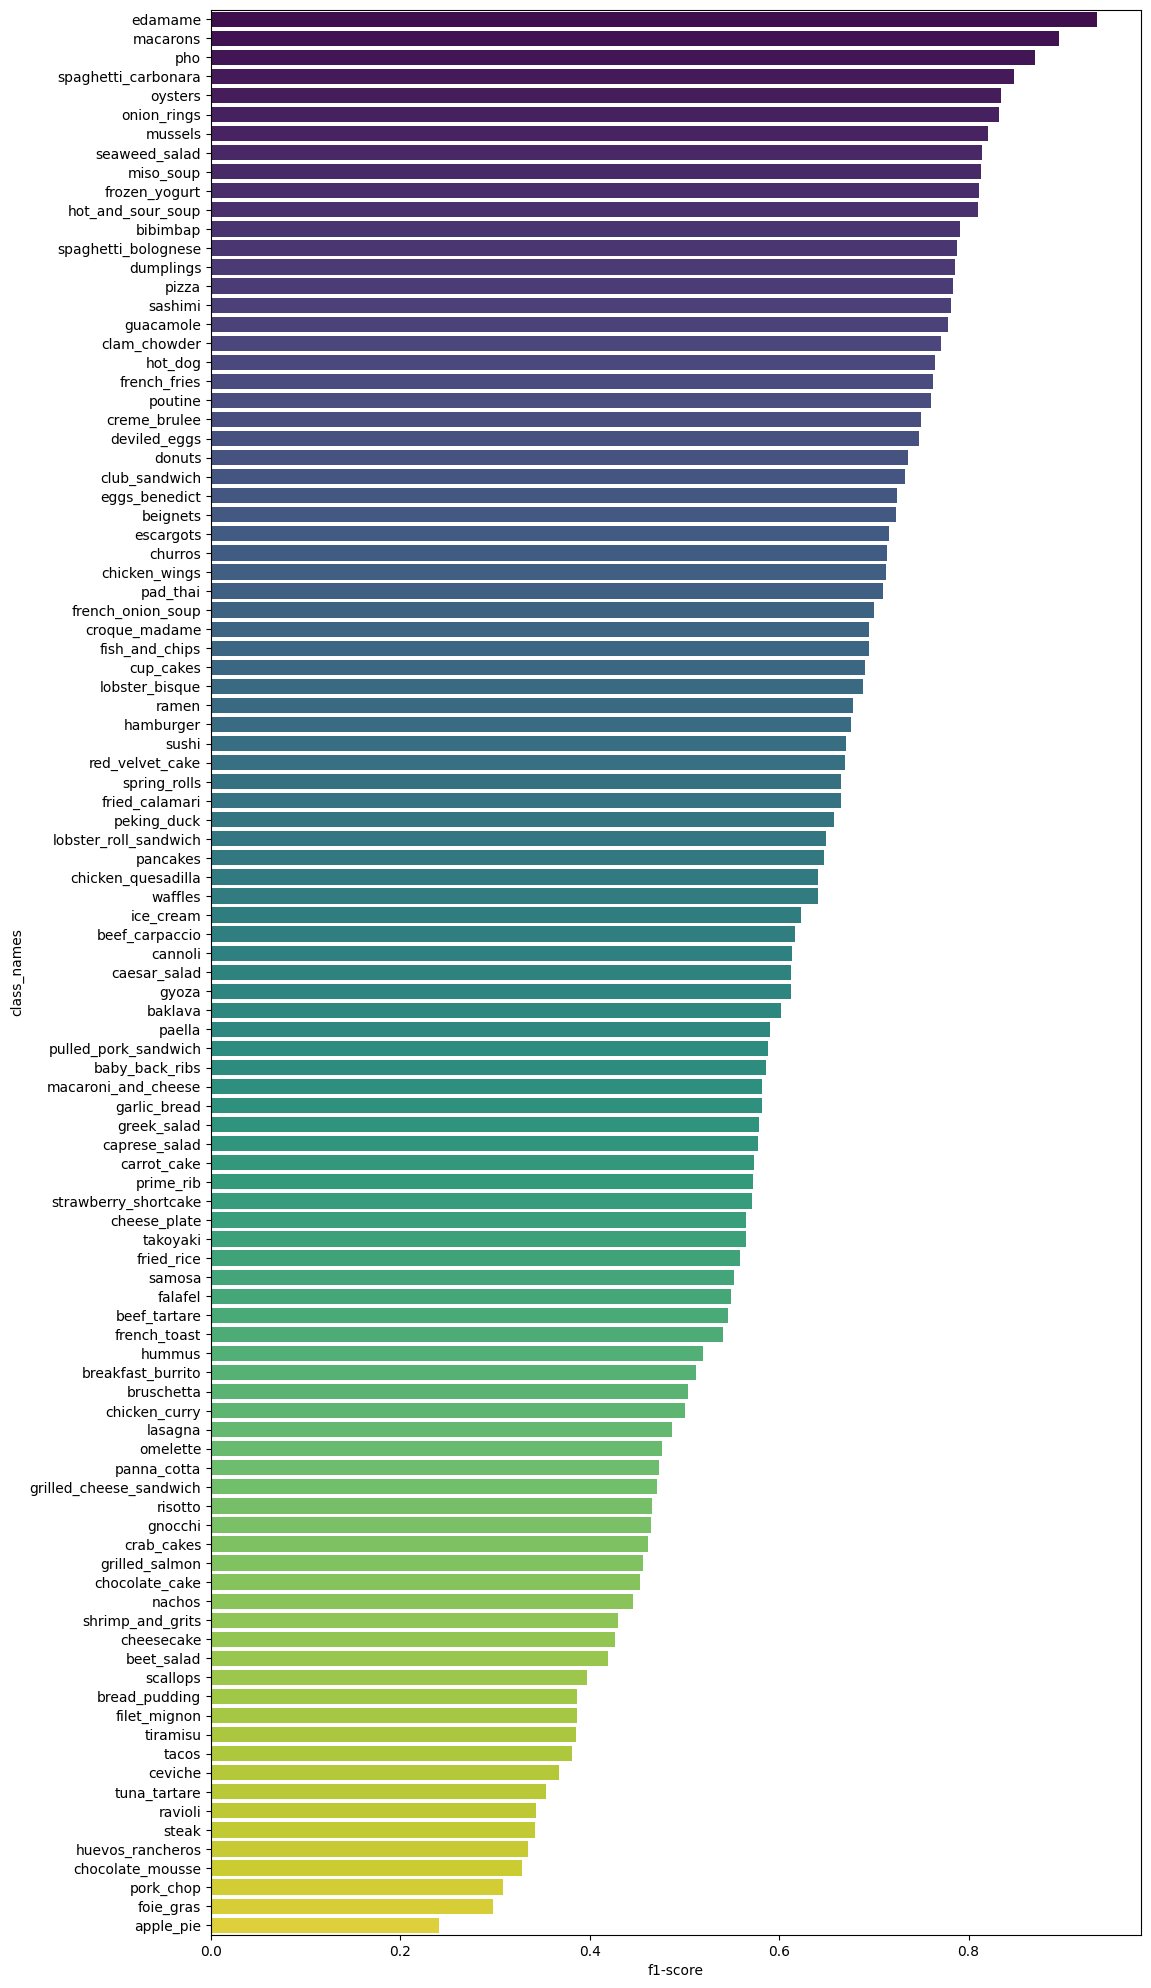

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
fig , ax = plt.subplots(figsize = (12,25))
scores = sns.barplot(x = "f1-score", y = "class_names", data = f1_scores, palette = "viridis")